<a href="https://colab.research.google.com/github/NerDucc/D-Parking/blob/master/YoloV8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the code

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 15 08:41:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Preprocessing code

In [ ]:
!pip install ultralytics


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
import os
if not os.path.isdir('PlateDetect-YoloV8'):
  os.makedirs('PlateDetect-YoloV8')

In [ ]:
%cd PlateDetect-YoloV8

/content/gdrive/MyDrive/PlateDetect-YoloV8


In [ ]:
%pwd


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-165-d3dc51b95a25>", line 1, in <module>
    get_ipython().run_line_magic('pwd', '')
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2314, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-84>", line 2, in pwd
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/osm.py", line 287, in pwd
    return os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in sho

OSError: ignored

In [ ]:
!echo 'train: /content/gdrive/MyDrive/PlateDetect-YoloV8/data/train' >> mydataset.yaml
!echo 'val: /content/gdrive/MyDrive/PlateDetect-YoloV8/data/val' >> mydataset.yaml
!echo 'nc: 1' >> mydataset.yaml
!echo "names: ['plate']" >> mydataset.yaml

# Training the model


## Import Yolov8 and using the yolov8m model

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO("/content/gdrive/MyDrive/PlateDetect-YoloV8/runs/detect/train6/weights/best.pt")

In [ ]:
%pwd

'/content/gdrive/MyDrive/PlateDetect-YoloV8'

## Training model (Epochs = 130, batch-size = 32)

In [ ]:
results = model.train(data="data/mydataset.yaml",batch=32, epochs=10)

## Continue training model (Epochs = 10, batch-size = 32)

In [ ]:
results = model.train(data="data/mydataset.yaml",batch=32, epochs=10)

In [ ]:
train2_result = model.val(data="data/mydataset.yaml")

In [ ]:
train2_info = model.info(verbose=True)

# Checking the matrix

In [ ]:
from IPython.display import display, Image
from IPython import display

In [ ]:
!ls /content/gdrive/MyDrive/PlateDetect-YoloV8/runs/detect/train6

args.yaml					   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1675828187.71a3d767cd63.873.1  train_batch2.jpg
events.out.tfevents.1675828187.71a3d767cd63.873.2  val_batch0_labels.jpg
F1_curve.png					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights


In [ ]:
Image(filename=f'/content/gdrive/MyDrive/PlateDetect-YoloV8/runs/detect/val/confusion_matrix.png', width=600);

# Processing 


## Label the object method

In [ ]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)): #das
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

## Plot the plate method

In [ ]:
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'plate'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  
  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image
  

In [ ]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# from paddleocr import PaddleOCR
!pip install paddleocr --upgrade

In [ ]:
!pip install paddlepaddle

In [ ]:
from paddleocr import PaddleOCR

In [ ]:
response = requests.get("https://tse4.mm.bing.net/th?id=OIP.oXOvgT-sC7opHaw2lkphLgHaFj&pid=Api&P=0")
image = Image.open(BytesIO(response.content))
image = np.asarray(image)

In [ ]:
results = model.predict(image)


0: 480x640 1 plate, 75.7ms
Speed: 0.7ms pre-process, 75.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


##Display the result

In [ ]:
display = plot_bboxes(image, results[0].boxes.boxes, score=True)
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  cv2_imshow(display) #if used in Colab
else :
  cv2.imshow(display) #if used in Python

## Crop the image

In [ ]:
def first_crop(img, results):
  box = results[0].boxes.boxes.cpu().numpy().astype(int)

  x1 = box[0][0]
  y1 = box[0][1]
  x2 = box[0][2]
  y2 = box[0][3]
 
  return image[y1:y2, x1:x2]

## Second crop for better result

In [ ]:
def secondCrop(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,0)
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    if(len(areas)!=0):
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        x,y,w,h = cv2.boundingRect(cnt)
        bounds = cv2.boundingRect(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        secondCrop = img[y:y+h,x:x+w]
    else:
        secondCrop = img
    return secondCrop

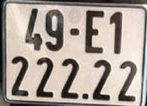

In [ ]:
firstCrop = first_crop(image, results)
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  cv2_imshow(firstCrop) #if used in Colab
else :
  cv2.imshow(firstCrop) #if used in Python

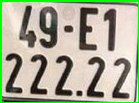

In [ ]:
finalCrop = secondCrop(firstCrop)
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  cv2_imshow(finalCrop) #if used in Colab
else :
  cv2.imshow(finalCrop) #if used in Python

In [ ]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')
result = ocr.ocr(firstCrop, det=False, cls=False)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

[2023/02/15 09:05:13] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set